Открываем исходный файл и файл с клиппингом.

*   wav_file_path - путь до исходного файла (без клиппинга), его данные записываются в массив samples
*   wav_file_path1 - путь до файла с клиппингом, его данные записываются в массив samples1



In [2]:
import wave
import numpy as np

def read_wav_as_float(file_path):
    """
    Reads a WAV file and returns its samples as a list of floating-point values.

    Parameters:
        file_path (str): Path to the WAV file.

    Returns:
        list: A list of floating-point samples.
    """
    # Open the WAV file
    with wave.open(file_path, 'rb') as wav_file:
        # Get parameters
        n_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        n_frames = wav_file.getnframes()
        frame_rate = wav_file.getframerate()

        print(f"Channels: {n_channels}, Sample Width: {sample_width}, Frame Rate: {frame_rate}, Frames: {n_frames}")

        # Read frames as bytes
        raw_data = wav_file.readframes(n_frames)

    # Determine the data type based on sample width
    dtype = {1: np.int8, 2: np.int16, 4: np.int32}.get(sample_width)
    if dtype is None:
        raise ValueError(f"Unsupported sample width: {sample_width}")

    # Convert raw bytes to numpy array
    int_data = np.frombuffer(raw_data, dtype=dtype)

    # Normalize to floating-point range [-1.0, 1.0]
    max_val = float(2 ** (8 * sample_width - 1))
    float_data = int_data / max_val

    # Handle multi-channel audio by averaging channels
    if n_channels > 1:
        float_data = float_data.reshape(-1, n_channels).mean(axis=1)

    return float_data.tolist()

# Example usage
wav_file_path = '1_16khz.wav'  # Replace with the path to your WAV file
wav_file_path1 = '1c_16khz.wav'
samples = read_wav_as_float(wav_file_path)
samples1 = read_wav_as_float(wav_file_path1)

Channels: 1, Sample Width: 2, Frame Rate: 16000, Frames: 44582
Channels: 1, Sample Width: 2, Frame Rate: 16000, Frames: 44582


Функция для записи массива в файл по пути output_path.

In [3]:
def write_float_samples_to_wav(samples, sample_rate, output_path):
    """
    Writes floating-point audio samples to a mono 16-bit WAV file.

    Parameters:
        samples (list or np.ndarray): Array of floating-point audio samples in the range [-1.0, 1.0].
        sample_rate (int): Sample rate of the audio in Hz (e.g., 44100).
        output_path (str): Path to save the output WAV file.
    """
    # Ensure the samples are a NumPy array
    samples = np.array(samples, dtype=np.float32)

    # Clip the samples to the range [-1.0, 1.0] to prevent overflow
    samples = np.clip(samples, -1.0, 1.0)

    # Convert to 16-bit PCM format
    int_samples = (samples * 32767).astype(np.int16)

    # Write to a WAV file
    with wave.open(output_path, 'wb') as wav_file:
        # Set the parameters for the WAV file
        wav_file.setnchannels(1)  # Mono
        wav_file.setsampwidth(2)  # 16-bit PCM
        wav_file.setframerate(sample_rate)

        # Write the audio frames
        wav_file.writeframes(int_samples.tobytes())
#import random
#for i in range(100):
#  start = random.randint(0,len(samples1))
#  samples1[start:start+15] = [1e-10]*15
#write_float_samples_to_wav(samples1, 16000, "1c16zeros.wav")

Разбиваем оба файла на последовательности по SQNC_LENGTH сэмплов, сэмплы исходного файла в samples_sequences, искаженного в sampeles_sequences_clipped.

In [4]:
j = 0
SQNC_LENGTH = 256
samples_sequences = []
samples_sequences_clipped = []
while j < len(samples1):
    if(j+SQNC_LENGTH < len(samples1)):
        samples_sequences.append(samples[j:j+SQNC_LENGTH])
        samples_sequences_clipped.append(samples1[j:j+SQNC_LENGTH])
    j += SQNC_LENGTH

Определение функций для расчета STFT (из них будут конструироваться лямбда-слои нейросети).

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
sample_rate = 16000
N, M = 5, 65  # Spectrogram dimensions
def stftLayer(x):
  #shape of the result is (a,b) where a = frame_length//2+1 and b = ceil(N//a), N - number of samples in original sequence
  frame_length = 8  # Frame length (number of samples per frame)
  frame_step = frame_length//2  # Step between frames (overlap)
  _, _, spctr = stft(np.array(x), sample_rate, nperseg=frame_length, noverlap=frame_step)
  ampsp = np.abs(spctr)
  phssp = tf.math.angle(spctr)
  return [ampsp,phssp]
def istftLayer(x):
  #shape of the result is (a,b) where a = frame_length//2+1 and b = ceil(N//a), N - number of samples in original sequence
  frame_length = 8  # Frame length (number of samples per frame)
  frame_step = frame_length//2  # Step between frames (overlap)
  spctrgrm = np.empty((N,M))
  spctrgrm = x[0]*np.exp(1j*x[1].numpy())
  _, x = istft(spctrgrm, sample_rate, nperseg=frame_length, noverlap=frame_step)
  return x
vect = np.random.rand(100)
print(vect)
print(istftLayer(stftLayer(vect)))
print(np.allclose(vect,istftLayer(stftLayer(vect))))

[0.64056067 0.40246298 0.88205066 0.77975938 0.18904932 0.85755584
 0.93632471 0.93338508 0.56717193 0.80610048 0.08434357 0.38718286
 0.07343799 0.21485619 0.7256435  0.09407466 0.09873008 0.59429285
 0.53783392 0.73336627 0.06687493 0.50619323 0.20661733 0.13960165
 0.76882523 0.8952259  0.78210296 0.07378892 0.83271912 0.8609596
 0.86438795 0.04391888 0.83093308 0.85025293 0.881699   0.96590893
 0.03933076 0.8561037  0.29615883 0.49384924 0.36572454 0.56341997
 0.64883414 0.10031689 0.18757526 0.1534379  0.25904446 0.93148161
 0.52546306 0.34518337 0.73547386 0.37102495 0.75216786 0.10935446
 0.11232848 0.47520318 0.58614741 0.47252007 0.97915149 0.66950887
 0.50014616 0.4395424  0.15986174 0.94961139 0.3235126  0.24440106
 0.88867648 0.73386591 0.86532943 0.33644581 0.73276205 0.43252633
 0.13254588 0.3206621  0.14649955 0.68359135 0.2361629  0.99650101
 0.1492312  0.64351792 0.64870331 0.93856152 0.05776053 0.87160749
 0.74098046 0.61341909 0.69504226 0.73788866 0.7446401  0.49160

Заполнение массива спектрограмм сигнала. Zxx - амплитудная спектрограмма последовательностей исходного сигнала, Zxx1 - амплитудная спектрограмма последовательностей сигнала с клиппингом. phs и phs1 - соответствующие фазовые спектрограмма последовательностей

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
Zxx = []
Zxx1 = []
phs = []
phs1 = []
fs = 16000
t = np.linspace(0, 1.0, SQNC_LENGTH, endpoint=False)  # Time vector
for i in range(len(samples_sequences_clipped)):
  signal = samples_sequences[i]
  signal1 = samples_sequences_clipped[i]
  # Parameters for STFT

  #shape of the result is (a,b) where a = frame_length//2+1 and b = ceil(N//a), N - number of samples in original sequence
  frame_length = 8  # Frame length (number of samples per frame)
  frame_step = frame_length//2  # Step between frames (overlap)

  # Compute the STFT using scipy's stft function
  f, t_stft, Z = stft(signal, fs, nperseg=frame_length, noverlap=frame_step)
  f1, t_stft1, Z1 = stft(signal1, fs, nperseg=frame_length, noverlap=frame_step)
  Zxx.append(np.abs(Z))
  Zxx1.append(np.abs(Z1))
  phs.append(tf.math.angle(Z))
  phs1.append(tf.math.angle(Z1))

Обучение нейросети на множестве спектрограмм сигнала. N и M - количество точек по осям частоты и времени соответственно в обучающих выборках.

In [28]:
from tensorflow.keras import layers, models
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Normalization, Lambda
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
N, M = 5, 65  # Spectrogram dimensions
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.95

lr_scheduler = LearningRateScheduler(scheduler)
def generate_identity_dataset(num_samples=1000):
    X = np.random.rand(num_samples, N, M)
    return X, X

'''def build_rnn_spectrogram_model(N, M):
    input_shape = (N, M, 1)  # Input shape for spectrograms

    input_tensor = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Reshape((N, M * 64))(x)
    x = layers.SimpleRNN(units=256, activation='relu', return_sequences=True)(x)
    x = layers.SimpleRNN(units=128, activation='relu', return_sequences=True)(x)
    x = layers.Dense(M, activation='linear')(x)
    x = layers.Reshape((N, M, 1))(x)


    # Add residual connection
    output_tensor = layers.Multiply()([input_tensor, x])
    model = Model(inputs=input_tensor, outputs=output_tensor)

    #model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])
    return model'''

def build_rnn_spectrogram_model(sq_lngth):
    input_shape = (sq_lngth)  # Input shape for spectrograms

    input_tensor = layers.Input(shape=(sq_lngth,))
    mag = Lambda(stftLayer,output_shape=(N,M))(input_tensor)[0].reshape((1,N,M,1))
    #.reshape((N,M,1))
    angle = Lambda(stftLayer,output_shape=(N,M))(input_tensor)[1].reshape((1,N,M,1))
    mag = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(mag)
    mag = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(mag)
    mag = layers.Reshape((N, M * 64))(mag)
    mag = layers.SimpleRNN(units=256, activation='relu', return_sequences=True)(mag)
    mag = layers.SimpleRNN(units=128, activation='relu', return_sequences=True)(mag)
    mag = layers.Dense(M, activation='linear')(mag)
    mag = layers.Reshape((1, N, M, 1))(mag)


    # Add residual connection
    #output_tensor = layers.Multiply()([input_tensor, mag])
    output_tensor = mag.reshape((N,M))
    ang = angle.reshape((N,M))
    print(output_tensor.shape,type(output_tensor))
    print(ang.shape,type(ang))
    #.reshape((sq_lngth,))
    #,output_shape=(sq_lngth,)
    result = Lambda(istftLayer)([output_tensor,ang])
    print("Input shape: ", input_tensor.shape)
    print("Output shape: ", result.shape)
    model = Model(inputs=input_tensor, outputs=result)

    #model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])
    #,run_eagerly=True
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'],run_eagerly=True)
    return model

from tensorflow.keras.callbacks import EarlyStopping


model = build_rnn_spectrogram_model(SQNC_LENGTH)
model.summary()
early_stopping = EarlyStopping(monitor='loss', patience=40, restore_best_weights=True)
#print(np.array(Zxx1).shape)
# Train model with normalized data
#model.fit(np.array(Zxx1), np.array(Zxx) , epochs=1000, callbacks=[early_stopping])
model.fit(samples_sequences_clipped, samples_sequences, epochs=1000, callbacks=[early_stopping])

(5, 65) <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
(5, 65) <class 'keras.src.backend.common.keras_tensor.KerasTensor'>


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(5, 65), dtype=float32, sparse=False, name=keras_tensor_318>', '<KerasTensor shape=(5, 65), dtype=float32, sparse=False, name=keras_tensor_319>'],)
  • kwargs={'mask': ['None', 'None']}

Открытие файла который нужно восстановить и получение массива его спектрограмм. file_for_restoration_path - путь к файлу который нужно восстановить.
samples_input_sequences - массив семплов этого файла

Zyy,phsy - массивы амплитудных и фазовых спектрограмм файла соответственно

In [ ]:
file_for_restoration_path = "one_c_16khz.wav"
samples_input_file = read_wav_as_float(file_for_restoration_path)
j = 0
SQNC_LENGTH = 256
fs = 44100
samples_input_sequences = []
while j < len(samples_input_file ):
    if(j+SQNC_LENGTH < len(samples_input_file)):
        samples_input_sequences.append(samples_input_file[j:j+SQNC_LENGTH])
    j += SQNC_LENGTH
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import wave
# Open the WAV file
with wave.open(file_for_restoration_path, 'rb') as wav_file:
    fs = wav_file.getframerate()
Zyy = []
phsy = []
t = np.linspace(0, 1.0, SQNC_LENGTH, endpoint=False)  # Time vector
for i in range(len(samples_input_sequences)):
  signal = samples_input_sequences[i]
  # Parameters for STFT

  #shape of the result is (a,b) where a = frame_length//2+1 and b = ceil(N//a), N - number of samples in original sequence
  frame_length = 8  # Frame length (number of samples per frame)
  frame_step = frame_length//2  # Step between frames (overlap)

  # Compute the STFT using scipy's stft function
  f, t_stft, Z = stft(signal, fs, nperseg=frame_length, noverlap=frame_step)
  Zyy.append(np.abs(Z))
  phsy.append(tf.math.angle(Z))

Channels: 1, Sample Width: 2, Frame Rate: 16000, Frames: 21362


Восстановление звука с помощью нейросети. samples_restored - массив восстановленных сэмплов звука.

In [ ]:
import cmath
import math
samples_restored = []
for i in range(len(Zyy)):
  t = np.linspace(0, 1.0, SQNC_LENGTH, endpoint=False)  # Time vector
  #shape of the result is (a,b) where a = frame_length//2+1 and b = ceil(N//a), N - number of samples in original sequence
  frame_length = 8  # Frame length (number of samples per frame)
  frame_step = 4  # Step between frames (overlap)
  spgram = np.empty((N,M))
  spgram = model.predict(Zyy[i].reshape(1,N,M)).reshape((N,M))*np.exp(1j*phsy[i].numpy())
  _, reconstructed_signal = istft(spgram, fs, nperseg=frame_length, noverlap=frame_step)
  samples_restored.append(reconstructed_signal[0:SQNC_LENGTH])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Если мы хотим произвести сравнение с каким-либо другим методом, возможно, возникнет проблема из-за разных длин файлов: текущий алгоритм отбрасывает последние сэмплы в файле чтобы достичь количества сэмплов кратного SQNC_LENGTH. Если раскомментировать вторую строку мы получим массив в котором недостающие восстановленные сэмплы заменены сэмплами исходного массива до требуемой длины, что обеспечит возможность сравнения файлов. output_path - название файла, в который будет записан вывод программы.

In [ ]:
samples_restored_final = samples_restored
samples_restored_final = np.append(np.array(samples_restored_final).flatten(),np.array(samples_input_file[len(samples_input_file)-(len(samples_input_file) % SQNC_LENGTH)::]))
import wave
import numpy as np

def write_float_samples_to_wav(samples, sample_rate, output_path):
    """
    Writes floating-point audio samples to a mono 16-bit WAV file.

    Parameters:
        samples (list or np.ndarray): Array of floating-point audio samples in the range [-1.0, 1.0].
        sample_rate (int): Sample rate of the audio in Hz (e.g., 44100).
        output_path (str): Path to save the output WAV file.
    """
    # Ensure the samples are a NumPy array
    samples = np.array(samples, dtype=np.float32)

    # Clip the samples to the range [-1.0, 1.0] to prevent overflow
    samples = np.clip(samples, -1.0, 1.0)

    # Convert to 16-bit PCM format
    int_samples = (samples * 32767).astype(np.int16)

    # Write to a WAV file
    with wave.open(output_path, 'wb') as wav_file:
        # Set the parameters for the WAV file
        wav_file.setnchannels(1)  # Mono
        wav_file.setsampwidth(2)  # 16-bit PCM
        wav_file.setframerate(sample_rate)

        # Write the audio frames
        wav_file.writeframes(int_samples.tobytes())

output_path = 'output.wav'  # Path to save the WAV file

write_float_samples_to_wav(samples_restored_final, fs, output_path)
print(f"WAV file written to {output_path}")


WAV file written to output.wav


Занимательные картинки.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


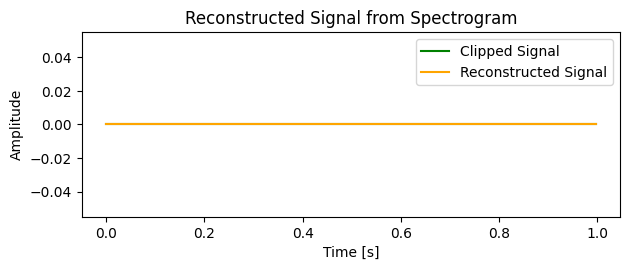

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


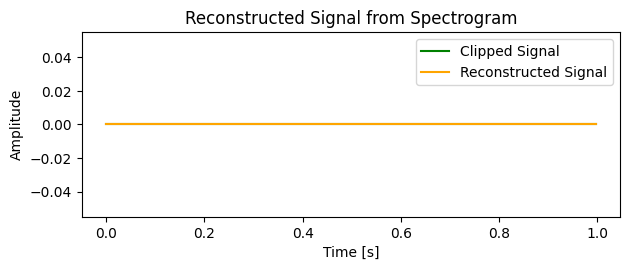

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


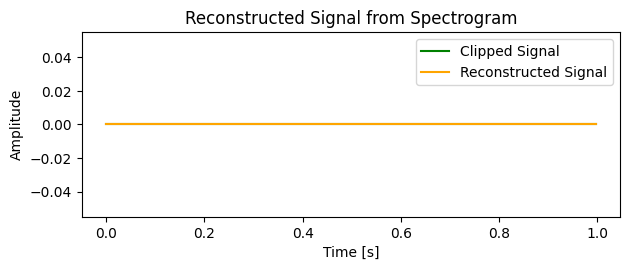

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


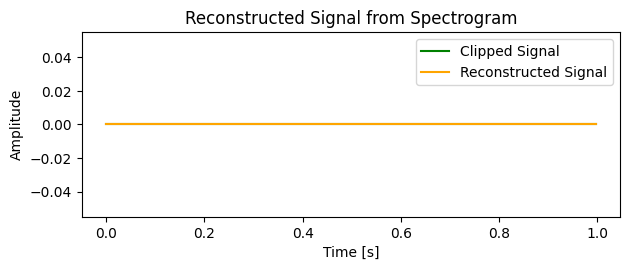

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


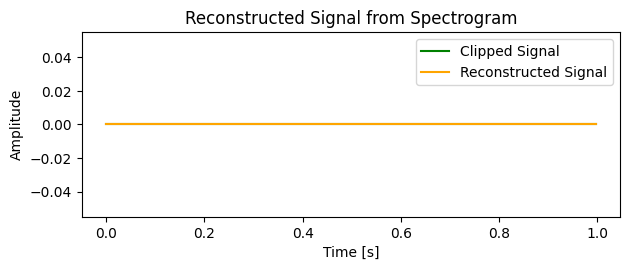

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


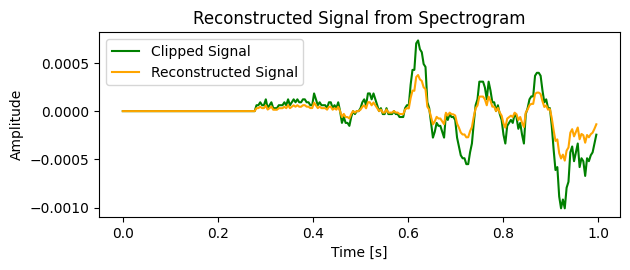

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


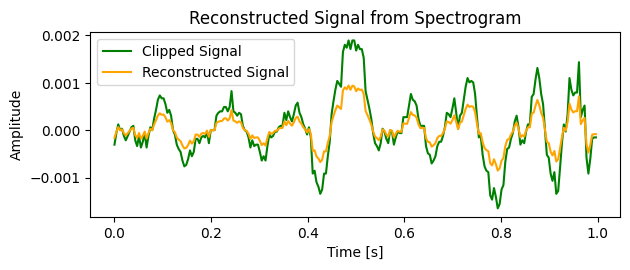

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


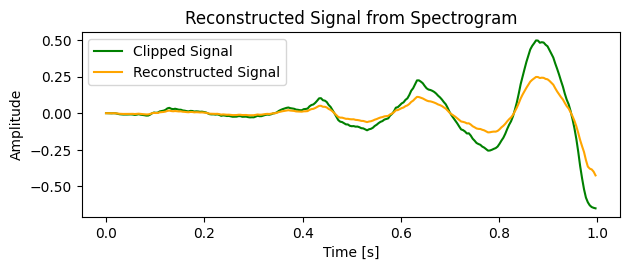

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


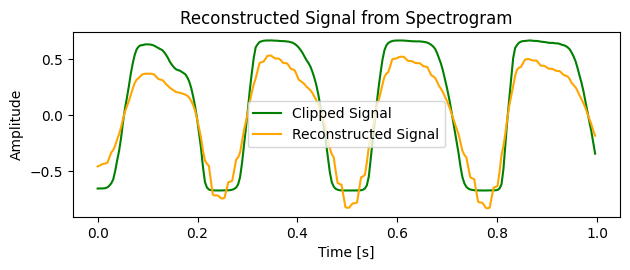

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


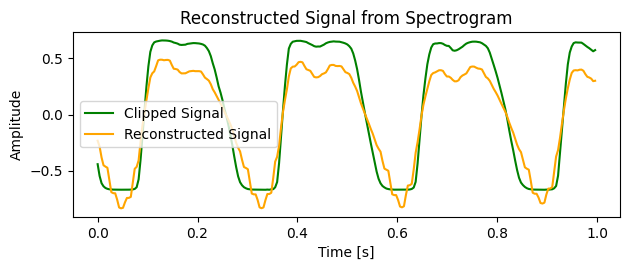

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


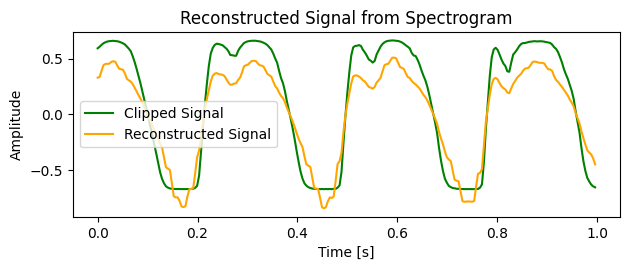

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


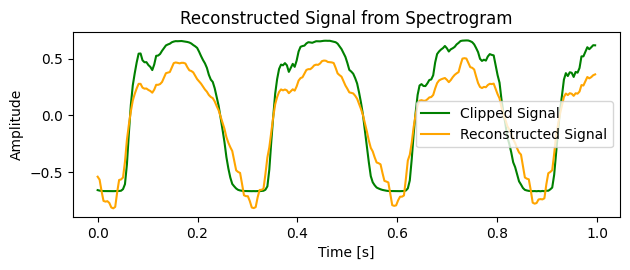

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


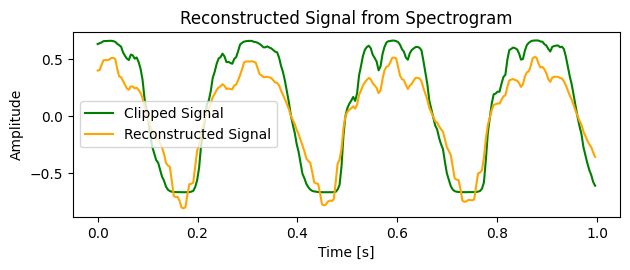

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


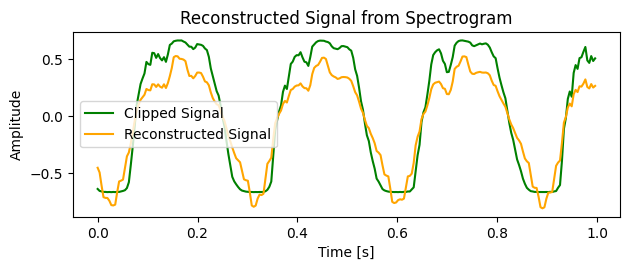

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


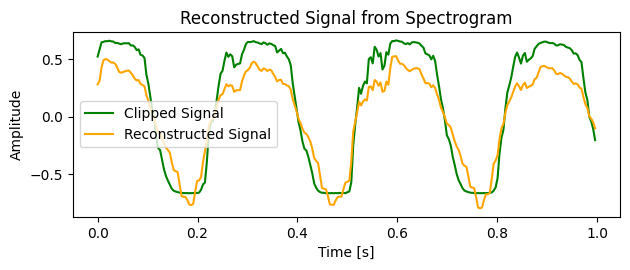

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


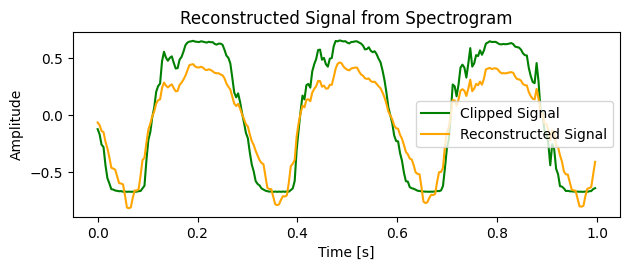

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


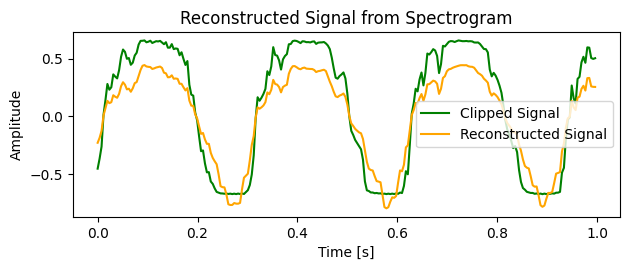

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


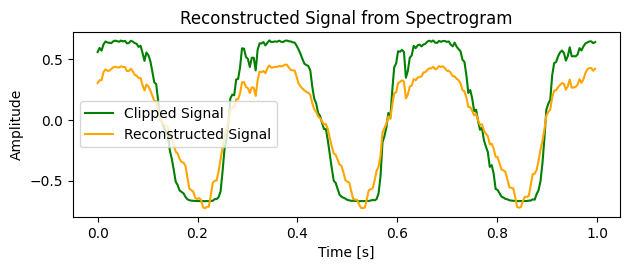

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


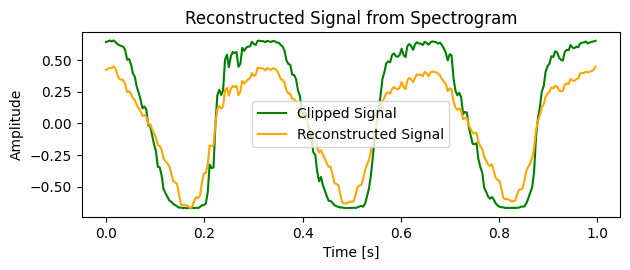

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


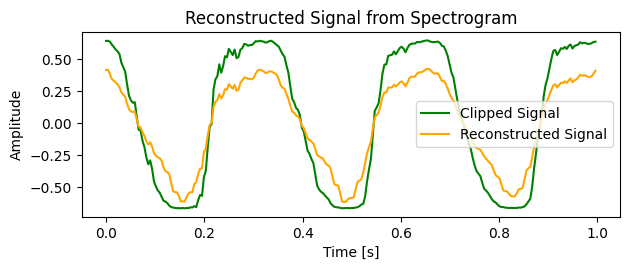

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


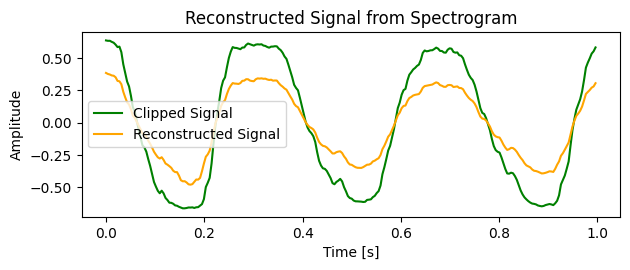

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


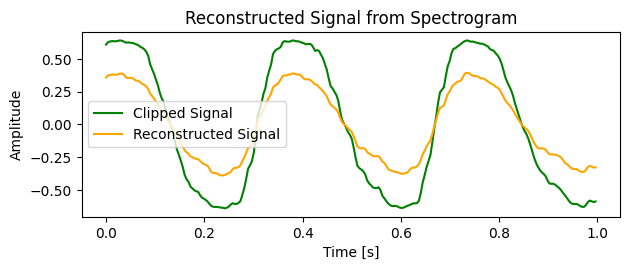

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


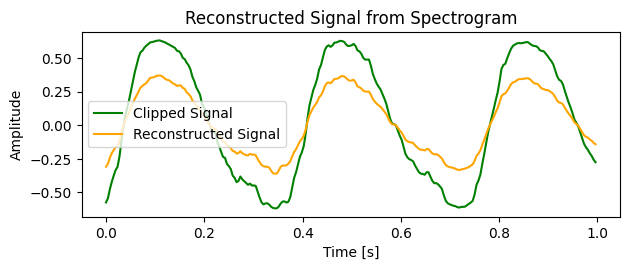

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


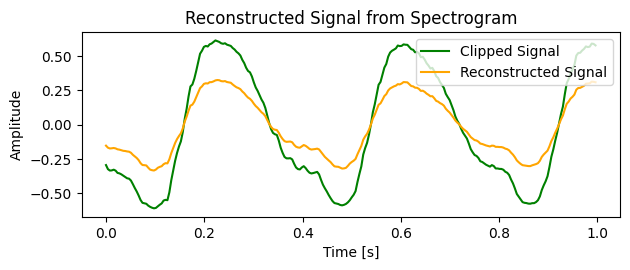

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


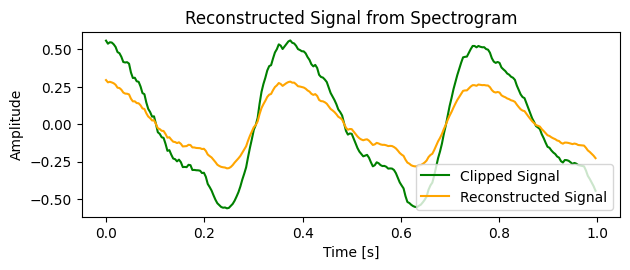

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


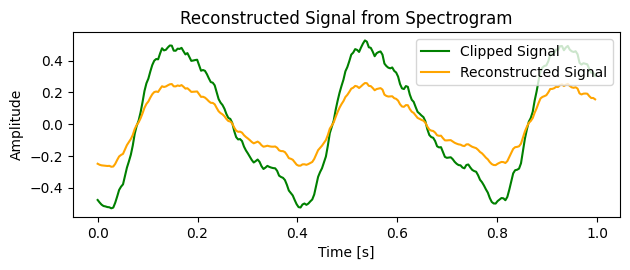

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


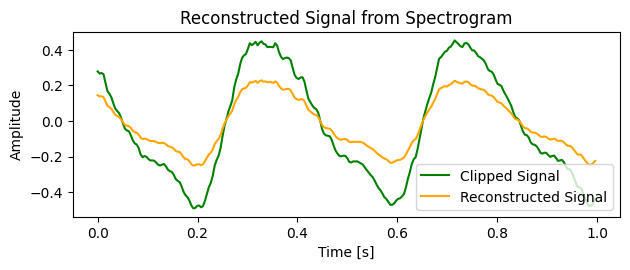

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


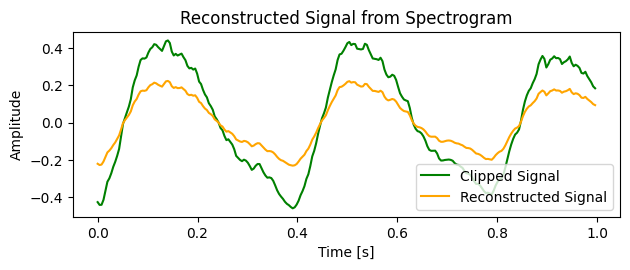

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


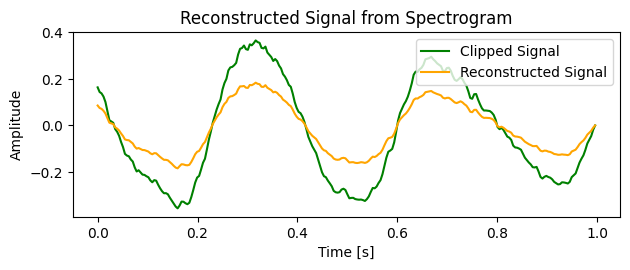

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


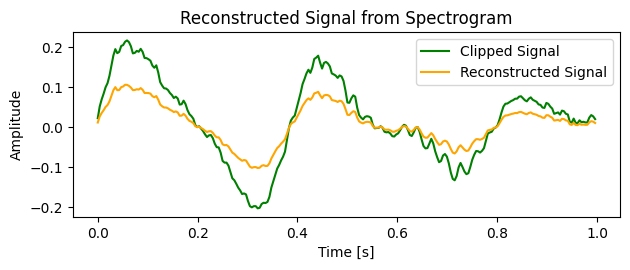

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


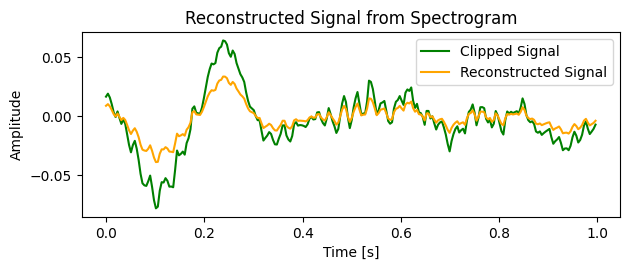

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


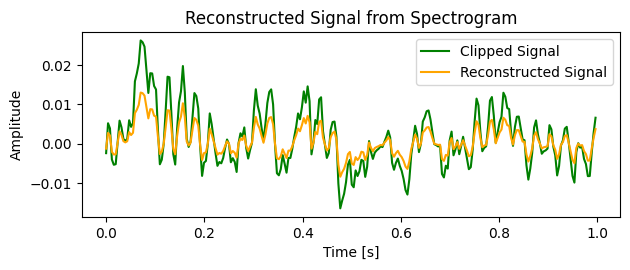

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


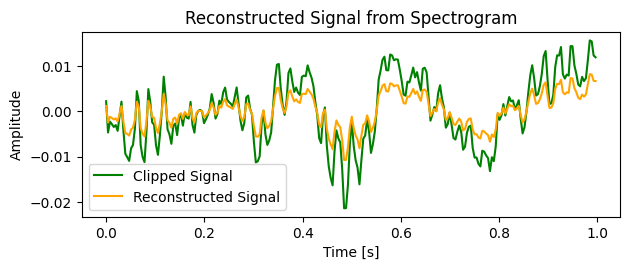

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


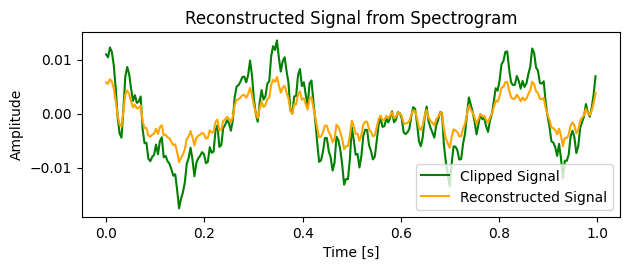

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


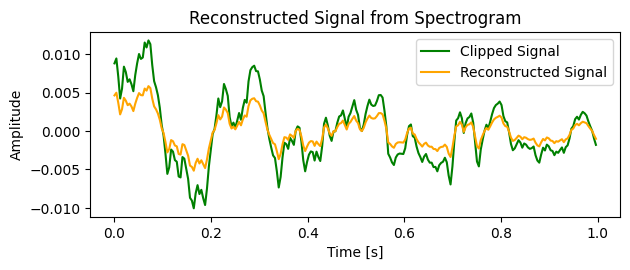

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


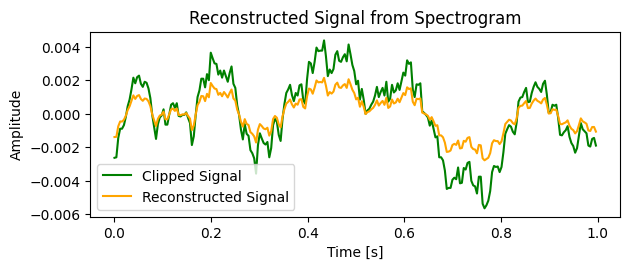

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


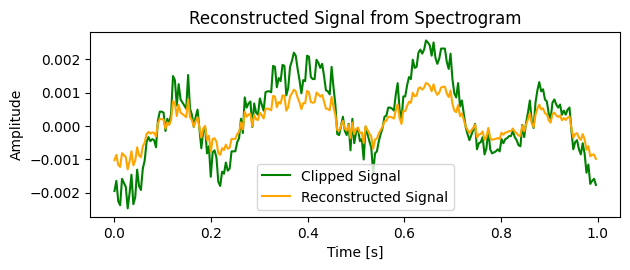

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


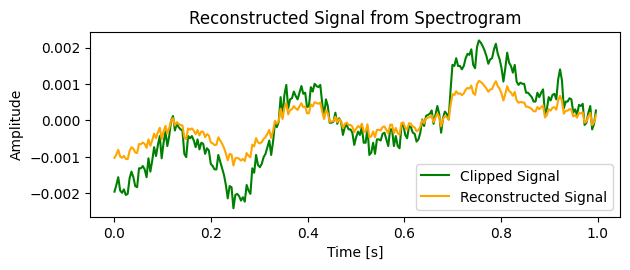

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


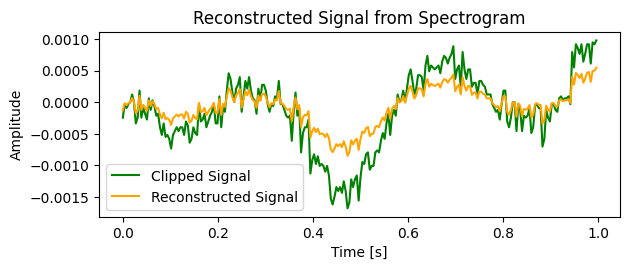

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


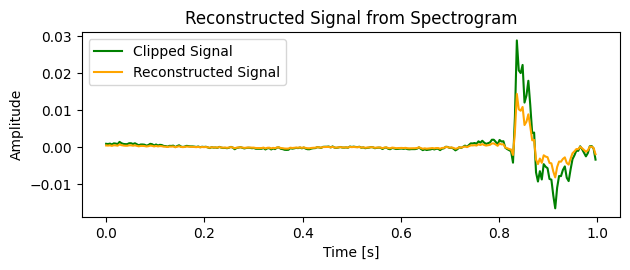

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


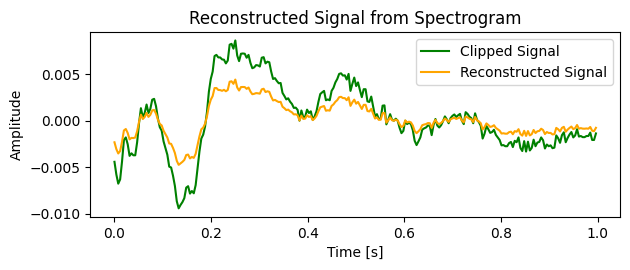

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


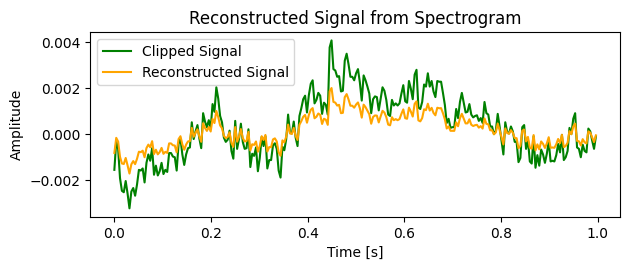

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


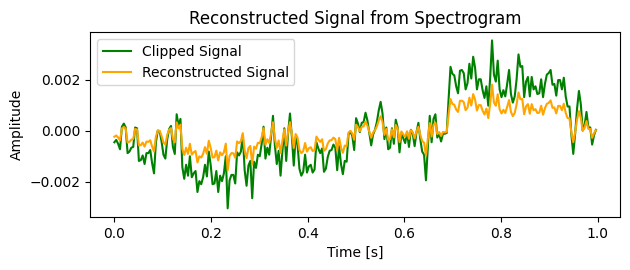

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


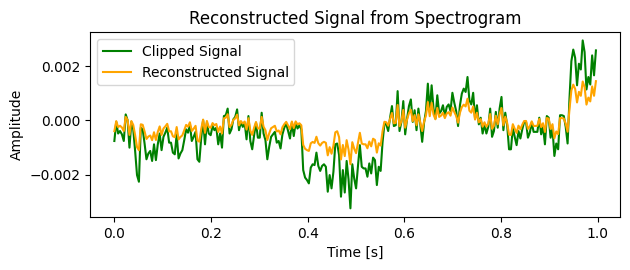

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


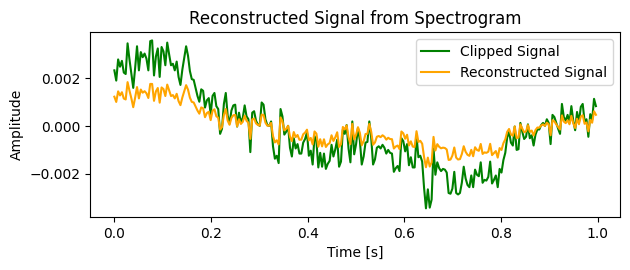

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


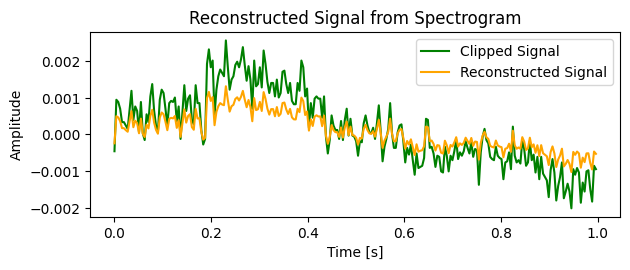

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


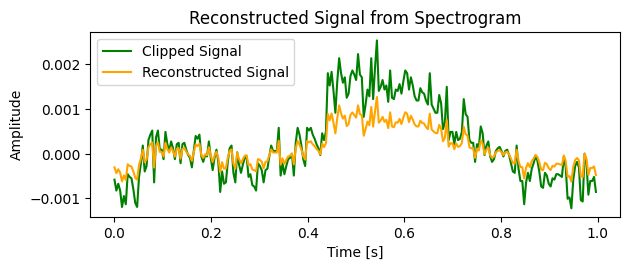

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


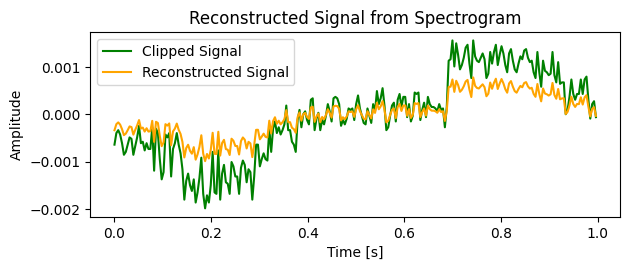

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


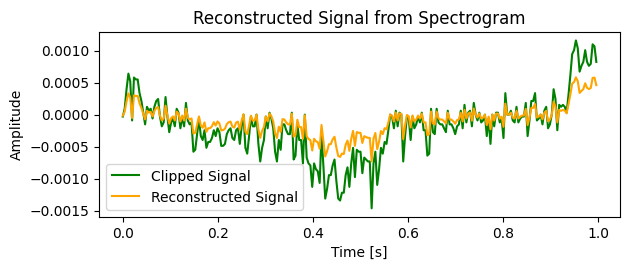

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


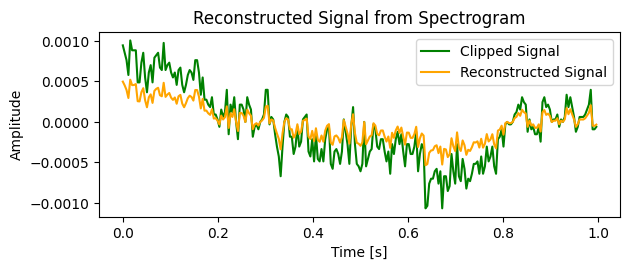

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


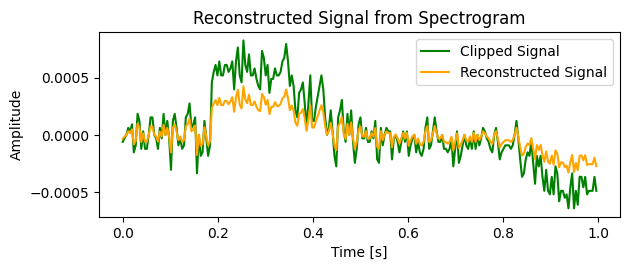

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


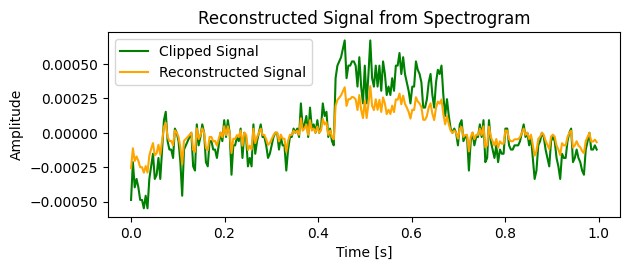

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


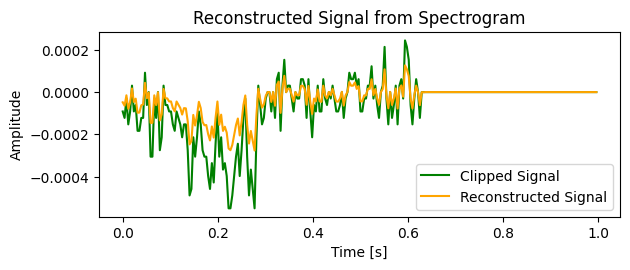

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


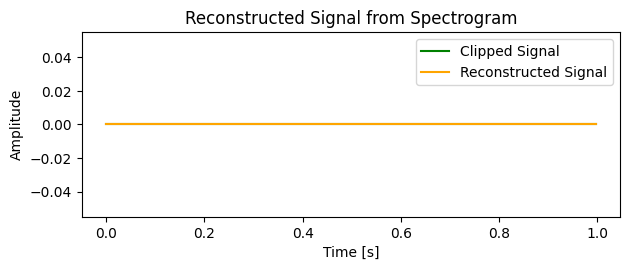

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


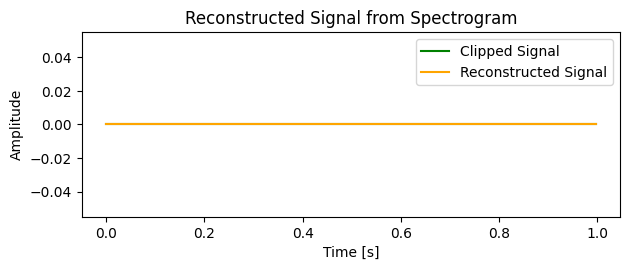

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


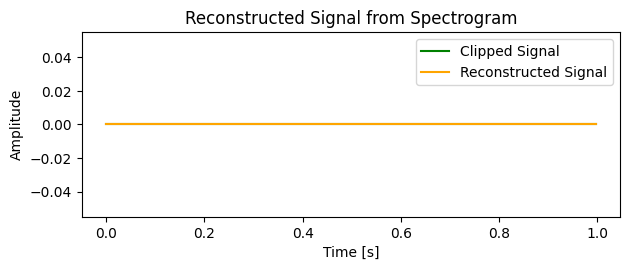

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


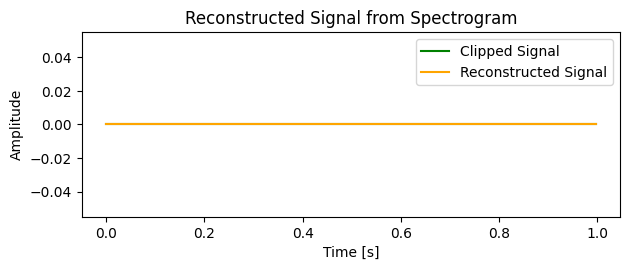

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


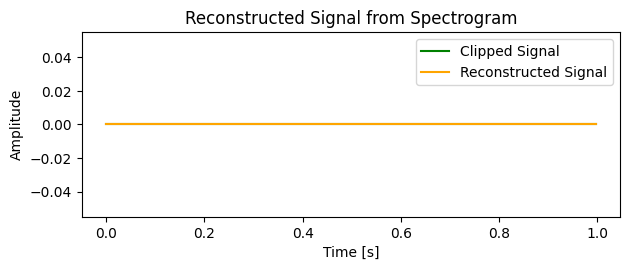

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


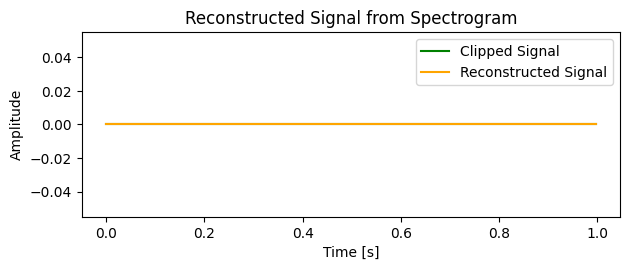

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


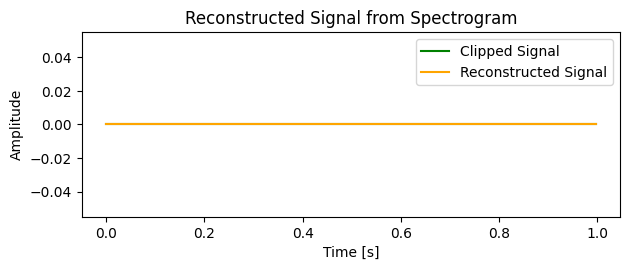

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


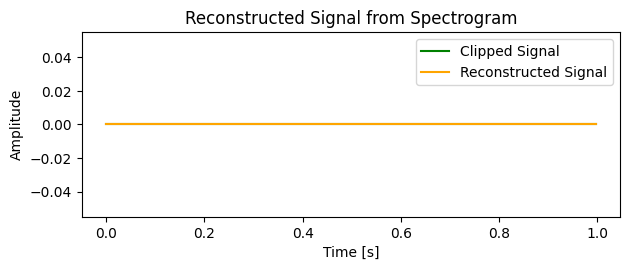

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


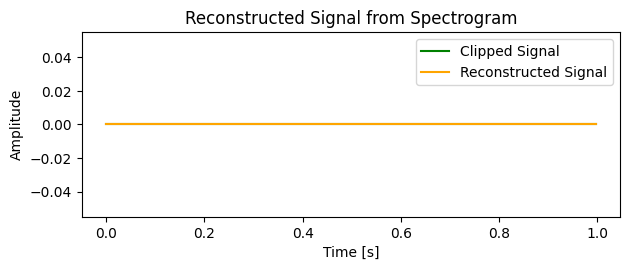

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


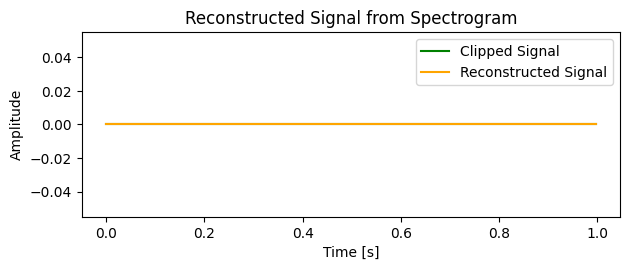

In [ ]:
import cmath
import math
for i in range(20,len(samples_input_sequences)):
  fs = 44100
  t = np.linspace(0, 1.0, SQNC_LENGTH, endpoint=False)  # Time vector
  #shape of the result is (a,b) where a = frame_length//2+1 and b = ceil(N//a), N - number of samples in original sequence
  frame_length = 8  # Frame length (number of samples per frame)
  frame_step = 4  # Step between frames (overlap)
  spgram = np.empty((N,M))
  #for j in range(N):
    #for k in range(M):
  spgram=model.predict(Zyy[i].reshape(1,N,M)).reshape((N,M))*np.exp(1j*phsy[i].numpy())
  #print(Zxx1[10]*(math.cos(phs[10])+1j*math.sin(phs[10])))
  #print(spgram[8][2])
  _, reconstructed_signal = istft(spgram, fs, nperseg=frame_length, noverlap=frame_step)

  # Plot reconstructed signal
  plt.subplot(2, 1, 2)
  #plt.plot(t, samples_sequences[i], label="Original Signal", color='blue')
  plt.plot(t, samples_input_sequences[i], label="Clipped Signal", color='green')
  plt.plot(t, samples_restored[i], label="Reconstructed Signal", color='orange')
  plt.title('Reconstructed Signal from Spectrogram')
  plt.xlabel('Time [s]')
  plt.ylabel('Amplitude')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
print(samples_input_sequences[40])

[0.633941650390625, 0.630828857421875, 0.6312255859375, 0.62286376953125, 0.61614990234375, 0.60125732421875, 0.58258056640625, 0.586029052734375, 0.543243408203125, 0.449737548828125, 0.38433837890625, 0.3165283203125, 0.278839111328125, 0.2056884765625, 0.11712646484375, 0.085723876953125, 0.0147705078125, -0.05450439453125, -0.11505126953125, -0.175994873046875, -0.191986083984375, -0.224578857421875, -0.28216552734375, -0.33453369140625, -0.395599365234375, -0.458770751953125, -0.494232177734375, -0.526824951171875, -0.545684814453125, -0.52581787109375, -0.546234130859375, -0.5816650390625, -0.597686767578125, -0.618438720703125, -0.61932373046875, -0.626495361328125, -0.6390380859375, -0.641876220703125, -0.65008544921875, -0.655975341796875, -0.66180419921875, -0.661651611328125, -0.6591796875, -0.655303955078125, -0.65576171875, -0.65435791015625, -0.658966064453125, -0.653839111328125, -0.652801513671875, -0.640625, -0.629241943359375, -0.590789794921875, -0.4976806640625, -0.